In [1]:
# 1) Uninstall any existing AI Edge packages
!pip uninstall -y ai-edge-torch ai-edge-torch-nightly ai-edge-quantizer ai-edge-quantizer-nightly

# 2) Re-install the newest nightly packages together
!pip install --upgrade --pre ai-edge-torch-nightly ai-edge-quantizer-nightly


Found existing installation: ai-edge-torch-nightly 0.3.0.dev20250218
Uninstalling ai-edge-torch-nightly-0.3.0.dev20250218:
  Successfully uninstalled ai-edge-torch-nightly-0.3.0.dev20250218
Found existing installation: ai-edge-quantizer-nightly 0.0.1.dev20250218
Uninstalling ai-edge-quantizer-nightly-0.0.1.dev20250218:
  Successfully uninstalled ai-edge-quantizer-nightly-0.0.1.dev20250218
  Using cached ai_edge_torch_nightly-0.3.0.dev20250218-py3-none-any.whl (381 kB)
  Using cached ai_edge_quantizer_nightly-0.0.1.dev20250218-py3-none-any.whl (146 kB)


In [2]:
old_sd = torch.load("Fold3_NoDistill_best_loss_weights.pth", map_location="cpu",weights_only=True)
for k in old_sd.keys():
    print(k)


time2vec.lin_weight
time2vec.lin_bias
time2vec.per_weight
time2vec.per_bias
input_proj.weight
input_proj.bias
encoder.layers.0.self_attn.in_proj_weight
encoder.layers.0.self_attn.in_proj_bias
encoder.layers.0.self_attn.out_proj.weight
encoder.layers.0.self_attn.out_proj.bias
encoder.layers.0.linear1.weight
encoder.layers.0.linear1.bias
encoder.layers.0.linear2.weight
encoder.layers.0.linear2.bias
encoder.layers.0.norm1.weight
encoder.layers.0.norm1.bias
encoder.layers.0.norm2.weight
encoder.layers.0.norm2.bias
encoder.layers.1.self_attn.in_proj_weight
encoder.layers.1.self_attn.in_proj_bias
encoder.layers.1.self_attn.out_proj.weight
encoder.layers.1.self_attn.out_proj.bias
encoder.layers.1.linear1.weight
encoder.layers.1.linear1.bias
encoder.layers.1.linear2.weight
encoder.layers.1.linear2.bias
encoder.layers.1.norm1.weight
encoder.layers.1.norm1.bias
encoder.layers.1.norm2.weight
encoder.layers.1.norm2.bias
encoder.layers.2.self_attn.in_proj_weight
encoder.layers.2.self_attn.in_proj_b

In [3]:
import ai_edge_torch
print("ai_edge_torch version:", ai_edge_torch.__version__)
help(ai_edge_torch.signature)


ai_edge_torch version: 0.3.0.dev20250218
Help on function signature in module ai_edge_torch._convert.converter:

signature(name: 'str', module: 'torch.nn.Module', sample_args=None, sample_kwargs=None, dynamic_shapes: 'Optional[Union[dict[str, Any], Tuple[Any, ...]]]' = None) -> 'Converter'
    Initiates a Converter object with the provided signature.
    
    Args:
      name: The name of the signature included in the converted edge model.
      module: The torch module to be converted.
      sample_args: Tuple of tensors by which the torch module will be traced with
        prior to conversion.
      sample_kwargs: Dict of str to tensor by which the torch module will be
        traced with prior to conversion.
      dynamic_shapes: Optional dict or tuple that specify dynamic shape
        specifications for each input in original order. See
        https://pytorch.org/docs/stable/export.html#expressing-dynamism for more
          details.
    
    Returns:
      A Converter object wit

In [6]:


##############################
# 1) Imports
##############################
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

# AI Edge Torch (make sure you're using version >= 0.3.x nightly)
import ai_edge_torch
from ai_edge_torch.generative.quantize import quant_recipes

##############################
# 2) Time2Vec Definition
##############################
class Time2Vec(nn.Module):
    """
    This matches the submodule named in your checkpoint:
      time2vec.lin_weight
      time2vec.lin_bias
      time2vec.per_weight
      time2vec.per_bias
    """
    def __init__(self, out_channels=8):
        super().__init__()
        self.out_channels = out_channels
        self.lin_weight = nn.Parameter(torch.randn(1))
        self.lin_bias   = nn.Parameter(torch.randn(1))
        if out_channels > 1:
            self.per_weight = nn.Parameter(torch.randn(out_channels - 1))
            self.per_bias   = nn.Parameter(torch.randn(out_channels - 1))
        else:
            self.per_weight = None
            self.per_bias   = None

    def forward(self, t):
        # shape of t: (N, 1), e.g. flatten (B*T, 1)
        t_lin = self.lin_weight * t + self.lin_bias
        if self.per_weight is not None:
            alpha = self.per_weight.unsqueeze(0)  # (1, out_channels-1)
            beta  = self.per_bias.unsqueeze(0)    # (1, out_channels-1)
            t_per = torch.sin(alpha * t + beta)
            return torch.cat([t_lin, t_per], dim=-1)
        else:
            return t_lin

##############################
# 3) Main Model Definition
##############################
class FallTime2VecTransformer(nn.Module):
    """
    This matches your original layering structure and parameter naming:
      - time2vec.* for Time2Vec
      - input_proj (linear)
      - encoder.layers.(0..2) => each has
          self_attn.in_proj_weight, self_attn.in_proj_bias,
          self_attn.out_proj.weight, self_attn.out_proj.bias,
          linear1.weight, linear1.bias, linear2.weight, linear2.bias,
          norm1.weight, norm1.bias, norm2.weight, norm2.bias
      - fc.weight, fc.bias
    """
    def __init__(self,
                 feat_dim=19,        # e.g. 3 accel channels + 16 Time2Vec => 19
                 d_model=64,
                 nhead=4,
                 num_layers=3,
                 num_classes=2,
                 time2vec_dim=16,
                 dropout=0.1,
                 dim_feedforward=128):
        super().__init__()
        self.feat_dim = feat_dim
        self.time2vec_dim = time2vec_dim

        # 1) The same time2vec submodule
        self.time2vec = Time2Vec(out_channels=time2vec_dim)

        # 2) Project input => d_model
        self.input_proj = nn.Linear(feat_dim, d_model)

        # 3) A standard PyTorch TransformerEncoder with `num_layers`.
        #    Each layer's internal submodules map exactly to the checkpoint keys:
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)

        # 4) Final classification
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, accel_xyz, accel_mask, accel_time):
        """
        accel_xyz:  (B, T, 3)  => raw accelerometer channels
        accel_mask: (B, T) bool => True means 'PAD' => used by Transformer
        accel_time: (B, T) => raw time indices
        """
        B, T, _ = accel_xyz.shape

        # Flatten time => pass through time2vec => reshape
        time_flat = accel_time.reshape(-1, 1)         # (B*T, 1)
        t_emb_flat = self.time2vec(time_flat)         # => (B*T, time2vec_dim)
        t_emb = t_emb_flat.view(B, T, self.time2vec_dim)

        # Concat => shape => (B, T, feat_dim)
        x = torch.cat([accel_xyz, t_emb], dim=-1)     # => 3 + time2vec_dim

        # Project
        x_proj = self.input_proj(x)                   # => (B, T, d_model)

        # Pass to Transformer
        out_seq = self.encoder(x_proj, src_key_padding_mask=accel_mask)

        # Global average pool
        feat = out_seq.mean(dim=1)

        # Final linear
        logits = self.fc(feat)
        return logits

##############################
# 4) Load Weights
##############################
def load_weights(model, ckpt_path):
    """
    Loads your original .pth. The checkpoint keys, for example, are:

      time2vec.lin_weight
      time2vec.lin_bias
      time2vec.per_weight
      ...
      encoder.layers.0.self_attn.in_proj_weight
      ...
      fc.weight
      fc.bias

    If no prefix, we can load directly:
    """
    ckpt = torch.load(ckpt_path, map_location='cpu')

    # If there's no mismatch (like "module." prefix), just load:
    model.load_state_dict(ckpt, strict=True)
    print(f"[INFO] Loaded weights from: {ckpt_path}")

##############################
# 5) Convert => TFLite
##############################
def convert_to_tflite(model,
                      tflite_path="fall_time2vec_transformer.tflite",
                      quantize=False):
    model.eval()

    # Example dummy input with (B=1, T=20)
    B = 1
    T = 20
    dummy_xyz  = torch.randn(B, T, 3, dtype=torch.float32)
    dummy_mask = torch.zeros(B, T, dtype=torch.bool)   # no pad
    dummy_time = torch.arange(T).unsqueeze(0).float()  # shape (1,T)

    # AI Edge Torch new signature uses sample_args= for input(s):
    converter = ai_edge_torch.signature(
        name="inference",
        module=model,
        sample_args=(dummy_xyz, dummy_mask, dummy_time),
    )

    quant_config = None
    if quantize:
        quant_config = quant_recipes.full_int8_weight_only_recipe()

    # Convert to TFLite
    tflite_model = converter.convert(quant_config=quant_config)
    tflite_model.export(tflite_path)
    print(f"[INFO] Exported TFLite model => {tflite_path}")

##############################
# 6) Main Orchestrator
##############################
if __name__ == "__main__":
    CKPT_PATH = "Fold3_NoDistill_best_loss_weights.pth"
    OUTPUT_TFLITE_PATH = "fall_time2vec_transformer.tflite"

    # Build model with same shapes used in your training
    model = FallTime2VecTransformer(
        feat_dim=19,      # e.g. 3 + 16
        d_model=64,
        nhead=4,
        num_layers=3,     # as your checkpoint uses layers.0, .1, .2
        num_classes=2,
        time2vec_dim=16,  # must match the time2vec block dimension
        dropout=0.1,
        dim_feedforward=128
    )

    # Load your trained checkpoint
    load_weights(model, CKPT_PATH)

    # Convert to TFLite
    convert_to_tflite(
        model,
        tflite_path=OUTPUT_TFLITE_PATH,
        quantize=False   # or True if you want int8 weight-only
    )


/tmp/ipykernel_95114/1121051200.py:145: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location='cpu')


[INFO] Loaded weights from: Fold3_NoDistill_best_loss_weights.pth


I0000 00:00:1739878493.214925   95114 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4057 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5


INFO:tensorflow:Assets written to: /tmp/tmpextvdr50/assets


INFO:tensorflow:Assets written to: /tmp/tmpextvdr50/assets


[INFO] Exported TFLite model => fall_time2vec_transformer.tflite


W0000 00:00:1739878494.673421   95114 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1739878494.673463   95114 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-02-18 05:34:54.674993: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpextvdr50
2025-02-18 05:34:54.675949: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-02-18 05:34:54.675962: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpextvdr50
I0000 00:00:1739878494.683861   95114 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled
2025-02-18 05:34:54.685245: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-02-18 05:34:54.751366: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpextvdr50
2025-02-18 05:34:54.765003: I tensorflow/cc/saved_model/loader.cc:471] SavedModel 

In [5]:
#!/usr/bin/env python
# coding: utf-8

import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

import ai_edge_torch  # AI Edge Torch for TFLite loading

##############################
# 0) CSV Parsing
##############################
def parse_watch_csv_timestamp(file_path: str):
    """
    Reads a CSV with columns:
      Column 0 => e.g. "YYYY-MM-DD HH:MM:SS.SSS" or numeric timestamps
      Columns 1..3 => x, y, z
    Returns float32 array (N,4): [seconds_since_start, x, y, z]
    """
    df = pd.read_csv(file_path, header=None, sep=None, engine='python')
    df = df.dropna(how='all').reset_index(drop=True)

    if df.shape[1] < 4:
        raise ValueError(f"CSV {file_path} requires >=4 columns [time_str, x, y, z].")

    time_strs = df.iloc[:, 0].astype(str)
    time_vals = pd.to_datetime(time_strs, errors='coerce')

    if time_vals.isnull().all():
        times = time_strs.astype(float)
        if times[0] > 1e10:
            times = times / 1000.0
        times = times - times[0]
    else:
        base_time = time_vals.iloc[0]
        times = (time_vals - base_time).dt.total_seconds().astype(np.float32)

    xyz = df.iloc[:, 1:4].values.astype(np.float32)
    return np.column_stack([times, xyz])

##############################
# 1) Time2Vec
##############################
class Time2Vec(nn.Module):
    def __init__(self, out_channels=8):
        super().__init__()
        self.out_channels = out_channels
        self.lin_weight = nn.Parameter(torch.randn(1))
        self.lin_bias   = nn.Parameter(torch.randn(1))
        if out_channels > 1:
            self.per_weight = nn.Parameter(torch.randn(out_channels - 1))
            self.per_bias   = nn.Parameter(torch.randn(out_channels - 1))
        else:
            self.per_weight = None
            self.per_bias   = None

    def forward(self, t):
        t_lin = self.lin_weight * t + self.lin_bias
        if self.per_weight is not None:
            alpha = self.per_weight.unsqueeze(0)
            beta  = self.per_bias.unsqueeze(0)
            t_per = torch.sin(alpha * t + beta)
            return torch.cat([t_lin, t_per], dim=-1)
        else:
            return t_lin

##############################
# 2) Transformer Model
##############################
class FallTime2VecTransformer(nn.Module):
    def __init__(self,
                 feat_dim=19,
                 d_model=64,
                 nhead=4,
                 num_layers=3,
                 num_classes=2,
                 time2vec_dim=16,
                 dropout=0.1,
                 dim_feedforward=128):
        super().__init__()
        self.time2vec_dim = time2vec_dim
        self.time2vec = Time2Vec(out_channels=time2vec_dim)
        self.input_proj = nn.Linear(feat_dim, d_model)
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, accel_seq, accel_mask, accel_time):
        B, T, _ = accel_seq.shape
        time_flat = accel_time.reshape(-1, 1)  # (B*T, 1)
        t_emb_flat = self.time2vec(time_flat)    # (B*T, time2vec_dim)
        t_emb = t_emb_flat.view(B, T, self.time2vec_dim)
        x = torch.cat([accel_seq, t_emb], dim=-1)  # (B, T, 3 + time2vec_dim)
        x_proj = self.input_proj(x)                # (B, T, d_model)
        out_seq = self.encoder(x_proj, src_key_padding_mask=accel_mask)
        feat = out_seq.mean(dim=1)
        logits = self.fc(feat)
        return logits

def load_weights(model, ckpt_path):
    sd = torch.load(ckpt_path, map_location="cpu")
    model.load_state_dict(sd, strict=True)
    print(f"[INFO] Loaded PyTorch weights from {ckpt_path}")

##############################
# 3) Main: Evaluate All Subjects & Log Details
##############################
def main():
    # User configuration
    MODEL_CKPT_PATH       = "Fold3_NoDistill_best_loss_weights.pth"
    TFLITE_PATH_FLOAT     = "fall_time2vec_transformer.tflite"
    TFLITE_PATH_INT8      = "fall_time2vec_transformer_int8.tflite"
    data_dir              = "./data/smartfallmm/young/accelerometer/watch"  # Directory containing CSV files
    seq_length            = 128

    # Set device for PyTorch (GPU if available)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model_pt = FallTime2VecTransformer(
        feat_dim=19,
        d_model=64,
        nhead=4,
        num_layers=3,
        num_classes=2,
        time2vec_dim=16,
        dropout=0.1,
        dim_feedforward=128
    ).to(device)
    load_weights(model_pt, MODEL_CKPT_PATH)
    model_pt.eval()

    # Print the PyTorch model architecture
    print("\n[INFO] PyTorch Model Architecture:")
    print(model_pt)

    # Load TFLite models (always on CPU)
    tfl_model_float = ai_edge_torch.model.TfLiteModel.load(TFLITE_PATH_FLOAT)
    tfl_model_int8  = ai_edge_torch.model.TfLiteModel.load(TFLITE_PATH_INT8)
    print(f"\n[INFO] Loaded TFLite (float) from {TFLITE_PATH_FLOAT}")
    print(f"[INFO] Loaded TFLite (int8)  from {TFLITE_PATH_INT8}")

    # (Optional) Print some info about TFLite models
    # We can't get an exact "layer listing," but we can show input/output details:
    print("\n[INFO] TFLite Float model input/output signatures (if available):")
    print(tfl_model_float)
    print("[INFO] TFLite Int8 model input/output signatures (if available):")
    print(tfl_model_int8)

    # Prepare statistics dictionaries: overall and per subject.
    overall_stats = {"total": 0, "pt_correct": 0, "float_correct": 0, "int8_correct": 0}
    subject_stats = {}

    # Process all CSV files ending with .csv in the data directory.
    csv_files = sorted(f for f in os.listdir(data_dir) if f.endswith(".csv"))
    if not csv_files:
        print(f"[WARN] No CSV files found in {data_dir}.")
        return

    for csv_name in csv_files:
        csv_path = os.path.join(data_dir, csv_name)

        # Expect filename format: SxxAyyTzz.csv
        if len(csv_name) < 9 or csv_name[0] != "S":
            print(f"[WARN] Unexpected filename format: {csv_name}, skipping.")
            continue

        subject = csv_name[:3]  # e.g. "S45", "S32", etc.
        action_str = csv_name[4:6]
        try:
            action_id = int(action_str)
        except Exception as e:
            print(f"[WARN] Could not parse action_id from {csv_name}: {e}, skipping.")
            continue

        # Determine ground truth: fall if action_id > 9.
        ground_truth = 1 if action_id > 9 else 0

        # Parse CSV file
        try:
            arr = parse_watch_csv_timestamp(csv_path)
        except Exception as e:
            print(f"[ERROR] Failed to parse {csv_name}: {e}")
            continue

        # Truncate or pad to fixed seq_length
        N = arr.shape[0]
        if N >= seq_length:
            arr = arr[:seq_length]
        else:
            pad_arr = np.zeros((seq_length - N, 4), dtype=np.float32)
            arr = np.concatenate([arr, pad_arr], axis=0)

        # Separate time and accelerometer data
        time_np = arr[:, 0]
        xyz_np  = arr[:, 1:4]

        # Create tensors and move to device
        B = 1
        accel_time = torch.from_numpy(time_np).unsqueeze(0).float().to(device)
        accel_seq  = torch.from_numpy(xyz_np).unsqueeze(0).float().to(device)
        accel_mask = torch.zeros((B, seq_length), dtype=torch.bool, device=device)

        # Run PyTorch inference
        with torch.no_grad():
            logits_pt = model_pt(accel_seq, accel_mask, accel_time)  # shape (1,2)
        pred_pt = int(logits_pt.argmax(dim=-1).item())
        # Convert to numpy for logging/comparison
        logits_pt_np = logits_pt.cpu().numpy()

        # Run TFLite float inference (inputs on CPU)
        logits_tf_float = tfl_model_float(
            accel_seq.cpu().numpy(),
            accel_mask.cpu().numpy(),
            accel_time.cpu().numpy(),
            signature_name="inference"
        )  # shape => (1,2)
        pred_float = int(np.argmax(logits_tf_float, axis=-1).item())

        # Run TFLite int8 inference (inputs on CPU)
        logits_tf_int8 = tfl_model_int8(
            accel_seq.cpu().numpy(),
            accel_mask.cpu().numpy(),
            accel_time.cpu().numpy(),
            signature_name="inference"
        )  # shape => (1,2)
        pred_int8 = int(np.argmax(logits_tf_int8, axis=-1).item())

        # Compare raw logits
        float_diff = np.abs(logits_pt_np - logits_tf_float).max()
        int8_diff  = np.abs(logits_pt_np - logits_tf_int8).max()

        # Update overall counters
        overall_stats["total"] += 1
        if pred_pt == ground_truth:
            overall_stats["pt_correct"] += 1
        if pred_float == ground_truth:
            overall_stats["float_correct"] += 1
        if pred_int8 == ground_truth:
            overall_stats["int8_correct"] += 1

        # Update per-subject stats
        if subject not in subject_stats:
            subject_stats[subject] = {"total": 0, "pt_correct": 0, "float_correct": 0, "int8_correct": 0}
        subject_stats[subject]["total"] += 1
        if pred_pt == ground_truth:
            subject_stats[subject]["pt_correct"] += 1
        if pred_float == ground_truth:
            subject_stats[subject]["float_correct"] += 1
        if pred_int8 == ground_truth:
            subject_stats[subject]["int8_correct"] += 1

        # Detailed debug log: show logits, predictions, differences
        print(
            f"[DEBUG] File: {csv_name} | Subj: {subject} | Action: {action_id} | "
            f"Samples: {N} | GT: {ground_truth} |\n"
            f"   PyTorch logits: {logits_pt_np}, pred={pred_pt}\n"
            f"   TFLite-float:  {logits_tf_float}, pred={pred_float}, diff vs PT={float_diff:.6f}\n"
            f"   TFLite-int8:   {logits_tf_int8}, pred={pred_int8}, diff vs PT={int8_diff:.6f}"
        )

    # Overall accuracy
    total = overall_stats["total"]
    if total > 0:
        acc_pt    = overall_stats["pt_correct"] / total
        acc_float = overall_stats["float_correct"] / total
        acc_int8  = overall_stats["int8_correct"] / total
    else:
        acc_pt = acc_float = acc_int8 = 0.0

    print("\n[OVERALL RESULTS]")
    print(f"  Total CSVs processed      : {total}")
    print(f"  PyTorch accuracy          : {acc_pt*100:.2f}%")
    print(f"  TFLite-float accuracy     : {acc_float*100:.2f}%")
    print(f"  TFLite-int8 accuracy      : {acc_int8*100:.2f}%")

    # Per-subject results
    print("\n[PER-SUBJECT RESULTS]")
    for subj, stats in subject_stats.items():
        subj_total = stats["total"]
        subj_acc_pt = stats["pt_correct"] / subj_total if subj_total > 0 else 0.0
        subj_acc_float = stats["float_correct"] / subj_total if subj_total > 0 else 0.0
        subj_acc_int8 = stats["int8_correct"] / subj_total if subj_total > 0 else 0.0
        print(f"  Subject {subj}: Processed = {subj_total}, "
              f"PyTorch Acc = {subj_acc_pt*100:.2f}%, "
              f"TFLite-float Acc = {subj_acc_float*100:.2f}%, "
              f"TFLite-int8 Acc = {subj_acc_int8*100:.2f}%")

    print("[INFO] Done.\n")


if __name__ == "__main__":
    main()


/tmp/ipykernel_217612/1288207221.py:109: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sd = torch.load(ckpt_path, map_location="cpu")


[INFO] Loaded PyTorch weights from Fold3_NoDistill_best_loss_weights.pth

[INFO] PyTorch Model Architecture:
FallTime2VecTransformer(
  (time2vec): Time2Vec()
  (input_proj): Linear(in_features=19, out_features=64, bias=True)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

[INFO] Loaded 

/tmp/ipykernel_217612/1288207221.py:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  time_vals = pd.to_datetime(time_strs, errors='coerce')
/tmp/ipykernel_217612/1288207221.py:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  time_vals = pd.to_datetime(time_strs, errors='coerce')
/tmp/ipykernel_217612/1288207221.py:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  time_vals = pd.to_datetime(time_strs, errors='coerce')
/tmp/ipykernel_217612/1288207221.py:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensu

[DEBUG] File: S33A02T09.csv | Subj: S33 | Action: 2 | Samples: 272 | GT: 0 |
   PyTorch logits: [[ 2.9320955 -2.484258 ]], pred=0
   TFLite-float:  [[ 2.932096  -2.4842575]], pred=0, diff vs PT=0.000000
   TFLite-int8:   [[ 2.9382963 -2.4872646]], pred=0, diff vs PT=0.006201
[DEBUG] File: S33A02T10.csv | Subj: S33 | Action: 2 | Samples: 339 | GT: 0 |
   PyTorch logits: [[ 2.9823725 -2.6383376]], pred=0
   TFLite-float:  [[ 2.9823723 -2.6383376]], pred=0, diff vs PT=0.000000
   TFLite-int8:   [[ 2.9834914 -2.6351683]], pred=0, diff vs PT=0.003169
[ERROR] Failed to parse S33A03T01.csv: could not convert string to float: 'X'
[ERROR] Failed to parse S33A03T02.csv: could not convert string to float: 'X'
[ERROR] Failed to parse S33A03T03.csv: could not convert string to float: 'X'
[ERROR] Failed to parse S33A03T04.csv: could not convert string to float: 'X'
[ERROR] Failed to parse S33A03T05.csv: could not convert string to float: 'X'
[DEBUG] File: S33A03T06.csv | Subj: S33 | Action: 3 | Samp

/tmp/ipykernel_217612/1288207221.py:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  time_vals = pd.to_datetime(time_strs, errors='coerce')
/tmp/ipykernel_217612/1288207221.py:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  time_vals = pd.to_datetime(time_strs, errors='coerce')
/tmp/ipykernel_217612/1288207221.py:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  time_vals = pd.to_datetime(time_strs, errors='coerce')
/tmp/ipykernel_217612/1288207221.py:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensu

[DEBUG] File: S33A06T06.csv | Subj: S33 | Action: 6 | Samples: 450 | GT: 0 |
   PyTorch logits: [[ 3.3125958 -2.8814857]], pred=0
   TFLite-float:  [[ 3.3125958 -2.881486 ]], pred=0, diff vs PT=0.000000
   TFLite-int8:   [[ 3.3128438 -2.8768263]], pred=0, diff vs PT=0.004659
[DEBUG] File: S33A06T07.csv | Subj: S33 | Action: 6 | Samples: 340 | GT: 0 |
   PyTorch logits: [[ 4.0305567 -3.6188986]], pred=0
   TFLite-float:  [[ 4.0305567 -3.618899 ]], pred=0, diff vs PT=0.000000
   TFLite-int8:   [[ 4.0300136 -3.6163473]], pred=0, diff vs PT=0.002551
[DEBUG] File: S33A06T08.csv | Subj: S33 | Action: 6 | Samples: 562 | GT: 0 |
   PyTorch logits: [[ 3.463415  -3.2650557]], pred=0
   TFLite-float:  [[ 3.4634151 -3.265055 ]], pred=0, diff vs PT=0.000001
   TFLite-int8:   [[ 3.464807  -3.2637098]], pred=0, diff vs PT=0.001392
[DEBUG] File: S33A06T09.csv | Subj: S33 | Action: 6 | Samples: 259 | GT: 0 |
   PyTorch logits: [[-3.9318042  3.9950194]], pred=1
   TFLite-float:  [[-3.931804   3.9950192]

/tmp/ipykernel_217612/1288207221.py:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  time_vals = pd.to_datetime(time_strs, errors='coerce')
/tmp/ipykernel_217612/1288207221.py:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  time_vals = pd.to_datetime(time_strs, errors='coerce')
/tmp/ipykernel_217612/1288207221.py:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  time_vals = pd.to_datetime(time_strs, errors='coerce')
/tmp/ipykernel_217612/1288207221.py:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensu

[DEBUG] File: S33A07T09.csv | Subj: S33 | Action: 7 | Samples: 335 | GT: 0 |
   PyTorch logits: [[ 2.7217624 -2.268472 ]], pred=0
   TFLite-float:  [[ 2.721763 -2.268472]], pred=0, diff vs PT=0.000000
   TFLite-int8:   [[ 2.7403107 -2.284096 ]], pred=0, diff vs PT=0.018548
[DEBUG] File: S33A07T10.csv | Subj: S33 | Action: 7 | Samples: 411 | GT: 0 |
   PyTorch logits: [[ 3.6546426 -3.2915661]], pred=0
   TFLite-float:  [[ 3.6546428 -3.2915664]], pred=0, diff vs PT=0.000000
   TFLite-int8:   [[ 3.6559973 -3.2906983]], pred=0, diff vs PT=0.001355
[DEBUG] File: S33A07T11.csv | Subj: S33 | Action: 7 | Samples: 340 | GT: 0 |
   PyTorch logits: [[ 3.7760544 -3.3656428]], pred=0
   TFLite-float:  [[ 3.7760544 -3.3656423]], pred=0, diff vs PT=0.000000
   TFLite-int8:   [[ 3.77726   -3.3624282]], pred=0, diff vs PT=0.003215
[DEBUG] File: S33A07T12.csv | Subj: S33 | Action: 7 | Samples: 385 | GT: 0 |
   PyTorch logits: [[ 3.8487709 -3.2726595]], pred=0
   TFLite-float:  [[ 3.8487701 -3.2726595]],

/tmp/ipykernel_217612/1288207221.py:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  time_vals = pd.to_datetime(time_strs, errors='coerce')
/tmp/ipykernel_217612/1288207221.py:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  time_vals = pd.to_datetime(time_strs, errors='coerce')
/tmp/ipykernel_217612/1288207221.py:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  time_vals = pd.to_datetime(time_strs, errors='coerce')
/tmp/ipykernel_217612/1288207221.py:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensu

[DEBUG] File: S33A11T02.csv | Subj: S33 | Action: 11 | Samples: 424 | GT: 1 |
   PyTorch logits: [[ 1.0838188 -0.5702174]], pred=0
   TFLite-float:  [[ 1.0838183  -0.57021695]], pred=0, diff vs PT=0.000000
   TFLite-int8:   [[ 1.0907328 -0.5755473]], pred=0, diff vs PT=0.006914
[DEBUG] File: S33A11T03.csv | Subj: S33 | Action: 11 | Samples: 288 | GT: 1 |
   PyTorch logits: [[ 1.9038173 -1.5378925]], pred=0
   TFLite-float:  [[ 1.9038173 -1.5378927]], pred=0, diff vs PT=0.000000
   TFLite-int8:   [[ 1.9121995 -1.5459596]], pred=0, diff vs PT=0.008382
[DEBUG] File: S33A11T04.csv | Subj: S33 | Action: 11 | Samples: 407 | GT: 1 |
   PyTorch logits: [[-0.8364209  1.6037045]], pred=1
   TFLite-float:  [[-0.83642066  1.6037043 ]], pred=1, diff vs PT=0.000000
   TFLite-int8:   [[-0.82508326  1.5894768 ]], pred=1, diff vs PT=0.014228
[DEBUG] File: S33A11T05.csv | Subj: S33 | Action: 11 | Samples: 38 | GT: 1 |
   PyTorch logits: [[-1.4905721  2.16663  ]], pred=1
   TFLite-float:  [[-1.4905717  2

/tmp/ipykernel_217612/1288207221.py:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  time_vals = pd.to_datetime(time_strs, errors='coerce')
/tmp/ipykernel_217612/1288207221.py:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  time_vals = pd.to_datetime(time_strs, errors='coerce')
/tmp/ipykernel_217612/1288207221.py:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  time_vals = pd.to_datetime(time_strs, errors='coerce')
/tmp/ipykernel_217612/1288207221.py:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensu

[DEBUG] File: S33A13T10.csv | Subj: S33 | Action: 13 | Samples: 304 | GT: 1 |
   PyTorch logits: [[-0.25307763  0.51056147]], pred=1
   TFLite-float:  [[-0.25307742  0.5105613 ]], pred=1, diff vs PT=0.000000
   TFLite-int8:   [[-0.22435239  0.4849959 ]], pred=1, diff vs PT=0.028725
[DEBUG] File: S33A13T11.csv | Subj: S33 | Action: 13 | Samples: 479 | GT: 1 |
   PyTorch logits: [[ 0.86701494 -0.30580837]], pred=0
   TFLite-float:  [[ 0.86701524 -0.30580863]], pred=0, diff vs PT=0.000000
   TFLite-int8:   [[ 0.86940974 -0.30843377]], pred=0, diff vs PT=0.002625
[ERROR] Failed to parse S33A14T01.csv: could not convert string to float: 'X'
[ERROR] Failed to parse S33A14T02.csv: could not convert string to float: 'X'
[ERROR] Failed to parse S33A14T03.csv: could not convert string to float: 'X'
[ERROR] Failed to parse S33A14T04.csv: could not convert string to float: 'X'
[DEBUG] File: S33A14T05.csv | Subj: S33 | Action: 14 | Samples: 137 | GT: 1 |
   PyTorch logits: [[ 2.899177  -2.5342162]]

In [2]:
!tree -d

.
├── TFLiteTest
│   ├── build
│   │   ├── classes
│   │   │   └── java
│   │   │       └── main
│   │   ├── generated
│   │   │   └── sources
│   │   │       ├── annotationProcessor
│   │   │       │   └── java
│   │   │       │       └── main
│   │   │       └── headers
│   │   │           └── java
│   │   │               └── main
│   │   └── tmp
│   │       └── compileJava
│   ├── gradle
│   │   └── wrapper
│   └── src
│       └── main
│           └── java
├── __pycache__
├── data
│   └── smartfallmm
│       ├── old
│       │   ├── accelerometer
│       │   │   ├── phone
│       │   │   └── watch
│       │   ├── gyroscope
│       │   │   ├── phone
│       │   │   └── watch
│       │   └── skeleton
│       └── young
│           ├── accelerometer
│           │   ├── phone
│           │   └── watch
│           ├── gyroscope
│           │   ├── phone
│           │   └── watch
│           └── skeleton
└── utils
    ├── __pycache__
    └── processor
        └── __pycache__

43 directories

   COMPLETE PYTORCH TO TFLITE CONVERSION
Model configuration: {'num_layers': 2, 'norm_first': True, 'embed_dim': 32, 'activation': 'relu', 'acc_coords': 4, 'num_classes': 1, 'acc_frames': 128, 'num_heads': 4}

1. Creating accelerometer-only model

2. Loading weights from: ttfstudent_31_woKD.pth

3. Creating sample input for model tracing

4. Testing PyTorch model inference
PyTorch model output shape: torch.Size([1, 1])
Raw output: [-1.0531094]
Binary predictions: [0]

5. Converting model to TFLite
=== Starting model conversion ===
Creating export-compatible wrapper...
Converting to AI Edge model...


/home/abheekp/tousifWeights/Torch_tflite/AI_EDGE_TORCH/lib/python3.12/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


INFO:tensorflow:Assets written to: /tmp/tmp3193imx8/assets


INFO:tensorflow:Assets written to: /tmp/tmp3193imx8/assets
W0000 00:00:1743306708.372103    2016 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1743306708.372159    2016 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-03-29 22:51:48.372365: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp3193imx8
2025-03-29 22:51:48.373219: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-03-29 22:51:48.373228: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp3193imx8
2025-03-29 22:51:48.379885: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-03-29 22:51:48.422952: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmp3193imx8
2025-03-29 22:51:48.436639: I tensorflow/cc/saved_model/loader.cc:471] SavedModel load for tags { serve }; Status: success: OK. Took 64278 

Conversion completed in 8.35 seconds
Exporting to TFLite format at: fall_detection_model.tflite

=== Verifying conversion accuracy ===
Max difference: 0.00000080
Outputs match: True
✅ Conversion successful with matching outputs!

6. Testing the converted model

Test case 1:

=== Comparing model outputs ===
Maximum difference: 0.00000080
Mean difference: 0.00000080
Outputs match: True


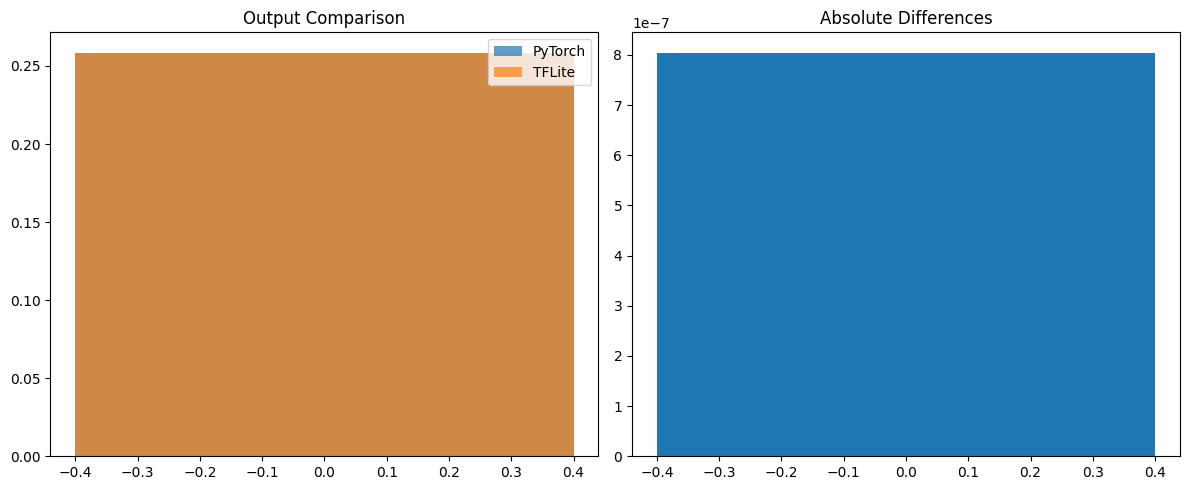


Test case 2:

=== Comparing model outputs ===
Maximum difference: 0.00000006
Mean difference: 0.00000006
Outputs match: True


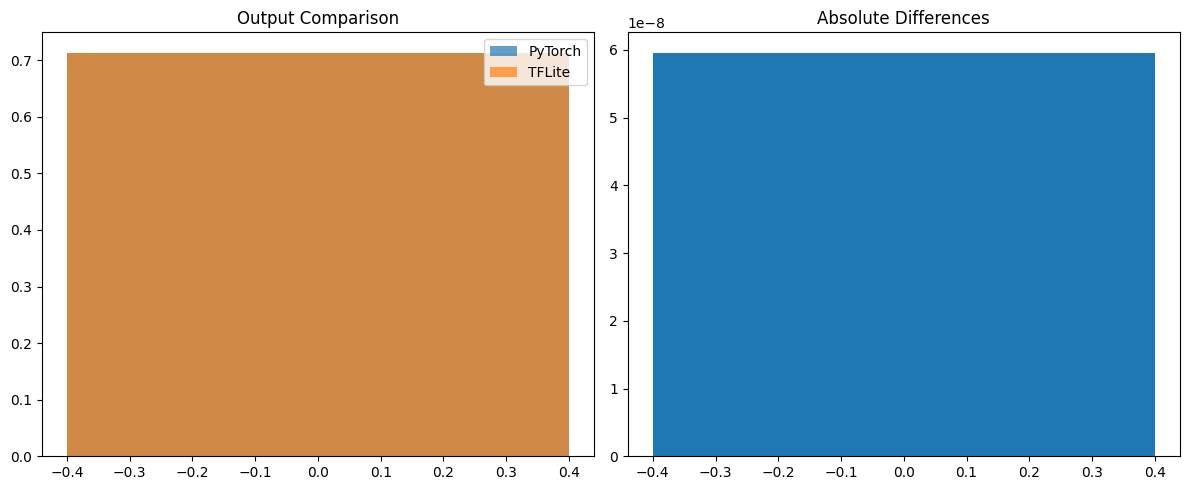


Test case 3:

=== Comparing model outputs ===
Maximum difference: 0.00000000
Mean difference: 0.00000000
Outputs match: True


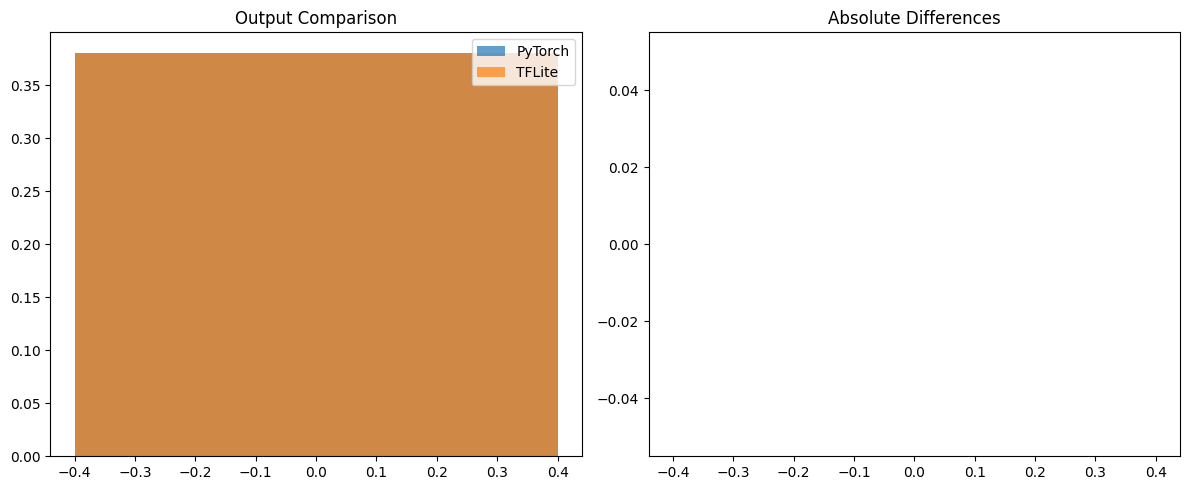


Test case 4:

=== Comparing model outputs ===
Maximum difference: 0.00000006
Mean difference: 0.00000006
Outputs match: True


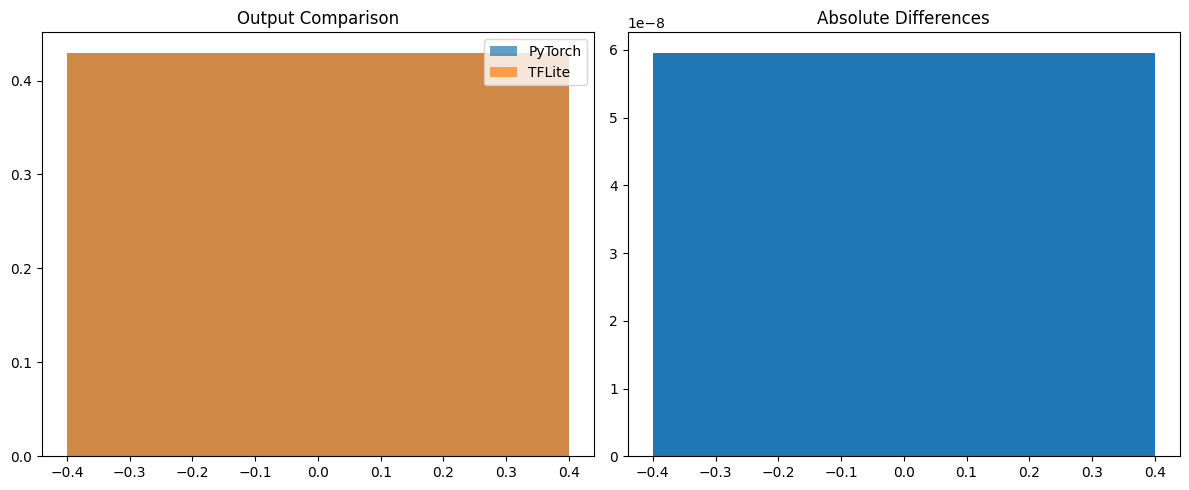


7. Testing the TFLite model directly

=== Testing TFLite model: fall_detection_model.tflite ===
Input details: [{'name': 'serving_default_args_0:0', 'index': 0, 'shape': array([  1, 128,   4], dtype=int32), 'shape_signature': array([  1, 128,   4], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output details: [{'name': 'StatefulPartitionedCall:0', 'index': 231, 'shape': array([1, 1], dtype=int32), 'shape_signature': array([1, 1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Running inference...
Raw output: [0.25862926]
Binary predictions (threshold=0.5): [0]

8. Conversion process completed!
TFLite model saved to: fall

/home/abheekp/tousifWeights/Torch_tflite/AI_EDGE_TORCH/lib/python3.12/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [2]:
# Complete TransModel to TFLite Conversion Script
# Compatible with Jupyter Notebook execution

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import traceback
import tempfile
import matplotlib.pyplot as plt
import time
import io

# Try importing ai_edge_torch, showing helpful error if not available
try:
    import ai_edge_torch
    from ai_edge_torch.debug import find_culprits
except ImportError:
    print("Error: ai_edge_torch not found.")
    print("Please install it with: pip install ai-edge-torch")
    print("For more details, see: https://github.com/google-ai-edge/ai-edge-torch")

# ==============================
# Revised TransModel (Acc Only)
# ==============================

class TransModel(nn.Module):
    def __init__(self,
                acc_frames=128,
                num_classes=1, 
                num_heads=4, 
                acc_coords=4,  # x, y, z, smv
                num_layers=2, 
                norm_first=True, 
                embed_dim=32, 
                activation='relu',
                **kwargs):
        super().__init__()
        
        self.data_shape = (acc_frames, acc_coords)
        self.length = self.data_shape[0]
        
        # Input projection: Conv1D to transform input channels into embedding dimension
        self.input_proj = nn.Sequential(
            nn.Conv1d(acc_coords, embed_dim, kernel_size=8, stride=1, padding='same'), 
            nn.BatchNorm1d(embed_dim)
        )

        # Transformer encoder layers
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,  
            activation=activation, 
            dim_feedforward=embed_dim*2, 
            nhead=num_heads,
            dropout=0.5,
            norm_first=norm_first
        )
        
        # Transformer encoder
        self.encoder = nn.TransformerEncoder(
            encoder_layer=self.encoder_layer, 
            num_layers=num_layers, 
            norm=nn.LayerNorm(embed_dim)
        )

        # Output classifier
        self.temporal_norm = nn.LayerNorm(embed_dim)
        self.output = nn.Linear(embed_dim, num_classes)
    
    def forward(self, acc_data):
        """Forward pass that only takes accelerometer data"""
        batch_size = acc_data.shape[0]
        
        # Reshape input: [batch, frames, channels] -> [batch, channels, frames]
        x = acc_data.permute(0, 2, 1)
        
        # Apply convolutional projection
        x = self.input_proj(x)  # Shape: [batch, embed_dim, frames]
        
        # Reshape for transformer: [batch, embed_dim, frames] -> [frames, batch, embed_dim]
        x = x.permute(2, 0, 1)
        
        # Apply transformer encoder
        x = self.encoder(x)  # Shape: [frames, batch, embed_dim]
        
        # Reshape back: [frames, batch, embed_dim] -> [batch, frames, embed_dim]
        x = x.permute(1, 0, 2)
        
        # Apply normalization
        x = self.temporal_norm(x)  # Shape: [batch, frames, embed_dim]
        
        # Global average pooling across time dimension
        # [batch, frames, embed_dim] -> [batch, embed_dim, frames]
        x = x.permute(0, 2, 1)
        x = F.avg_pool1d(x, kernel_size=x.shape[2], stride=1)  # Shape: [batch, embed_dim, 1]
        x = x.squeeze(-1)  # Shape: [batch, embed_dim]
        
        # Final classification
        x = self.output(x)  # Shape: [batch, num_classes]
        
        return x

# ==============================
# Model Wrapper for Export
# ==============================

class TransModelWrapper(nn.Module):
    """Wrapper to ensure compatibility with torch.export and AI Edge Torch"""
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def forward(self, acc_data):
        # Get model prediction and apply sigmoid
        logits = self.model(acc_data)
        probs = torch.sigmoid(logits)
        return probs

# ==============================
# Conversion Utilities
# ==============================

def convert_model_to_tflite(model, sample_input, output_path, debug=True):
    """
    Convert PyTorch model to TFLite using AI Edge Torch
    
    Args:
        model: PyTorch model to convert
        sample_input: Sample input tensor for tracing
        output_path: Path to save the TFLite model
        debug: Enable debugging mode
    
    Returns:
        edge_model: Converted AI Edge Torch model
    """
    print("=== Starting model conversion ===")
    
    # Set model to evaluation mode
    model.eval()
    
    # Create the wrapper for export compatibility
    print("Creating export-compatible wrapper...")
    wrapper = TransModelWrapper(model)
    wrapper.eval()
    
    try:
        # Start conversion
        print("Converting to AI Edge model...")
        conversion_start = time.time()
        
        # Convert model to AI Edge format
        edge_model = ai_edge_torch.convert(wrapper, (sample_input,))
        
        conversion_time = time.time() - conversion_start
        print(f"Conversion completed in {conversion_time:.2f} seconds")
        
        # Export to TFLite
        print(f"Exporting to TFLite format at: {output_path}")
        edge_model.export(output_path)
        
        # Verify the conversion by comparing outputs
        print("\n=== Verifying conversion accuracy ===")
        with torch.no_grad():
            pytorch_output = wrapper(sample_input).cpu().numpy()
        
        edge_output = edge_model(sample_input)
        
        # Compare outputs
        max_diff = np.max(np.abs(pytorch_output - edge_output))
        are_close = np.allclose(pytorch_output, edge_output, atol=1e-5)
        
        print(f"Max difference: {max_diff:.8f}")
        print(f"Outputs match: {are_close}")
        
        if are_close:
            print("✅ Conversion successful with matching outputs!")
        else:
            print("⚠️ Conversion completed but outputs don't match exactly.")
            
            # Show detailed comparison if differences are found
            if debug and not are_close:
                print("\nDetailed comparison:")
                print(f"PyTorch output: {pytorch_output.flatten()}")
                print(f"TFLite output: {edge_output.flatten()}")
        
        return edge_model
        
    except Exception as e:
        print(f"❌ Error during conversion: {str(e)}")
        
        if debug:
            print("\n=== DEBUG INFORMATION ===")
            traceback.print_exc()
            
            try:
                # Use AI Edge Torch's debugging tools to identify issues
                print("\nFinding culprits in the model...")
                culprits = find_culprits(wrapper, (sample_input,))
                
                if culprits:
                    print("\nProblematic operations found:")
                    for i, culprit in enumerate(culprits):
                        print(f"\n--- Culprit #{i+1} ---")
                        culprit.print_code()
                else:
                    print("No specific culprits identified.")
            except Exception as debug_e:
                print(f"Error during debugging: {str(debug_e)}")
        
        return None

def load_and_test_tflite(tflite_path, test_data):
    """
    Load and test a TFLite model
    
    Args:
        tflite_path: Path to the TFLite model
        test_data: Input data for testing
    
    Returns:
        predictions: Model predictions
    """
    try:
        # Try importing TensorFlow
        import tensorflow as tf
        
        print(f"\n=== Testing TFLite model: {tflite_path} ===")
        
        # Load the TFLite model
        interpreter = tf.lite.Interpreter(model_path=tflite_path)
        interpreter.allocate_tensors()
        
        # Get input and output details
        input_details = interpreter.get_input_details()
        output_details = interpreter.get_output_details()
        
        print(f"Input details: {input_details}")
        print(f"Output details: {output_details}")
        
        # Ensure test_data is in the right format (numpy array)
        if isinstance(test_data, torch.Tensor):
            test_data = test_data.numpy()
        
        # Set the input tensor
        interpreter.set_tensor(input_details[0]['index'], test_data)
        
        # Run inference
        print("Running inference...")
        interpreter.invoke()
        
        # Get the output
        output = interpreter.get_tensor(output_details[0]['index'])
        
        # Apply threshold for binary prediction
        predictions = (output > 0.5).astype(np.int32)
        
        print(f"Raw output: {output.flatten()}")
        print(f"Binary predictions (threshold=0.5): {predictions.flatten()}")
        
        return output
        
    except ImportError:
        print("TensorFlow not installed. Cannot test TFLite model.")
        print("Install with: pip install tensorflow")
        return None
    except Exception as e:
        print(f"Error testing TFLite model: {str(e)}")
        traceback.print_exc()
        return None

def compare_model_outputs(model, edge_model, test_data):
    """
    Compare outputs between original PyTorch model and converted model
    
    Args:
        model: Original PyTorch model
        edge_model: Converted AI Edge Torch model
        test_data: Test data for comparison
    """
    print("\n=== Comparing model outputs ===")
    
    # Set model to evaluation mode
    model.eval()
    
    # Create wrapper for consistent output format
    wrapper = TransModelWrapper(model)
    
    # Get outputs from both models
    with torch.no_grad():
        torch_output = wrapper(test_data).cpu().numpy()
    
    edge_output = edge_model(test_data)
    
    # Calculate differences
    max_diff = np.max(np.abs(torch_output - edge_output))
    mean_diff = np.mean(np.abs(torch_output - edge_output))
    are_close = np.allclose(torch_output, edge_output, atol=1e-5)
    
    print(f"Maximum difference: {max_diff:.8f}")
    print(f"Mean difference: {mean_diff:.8f}")
    print(f"Outputs match: {are_close}")
    
    # Visualize differences
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.bar(range(len(torch_output.flatten())), torch_output.flatten(), label='PyTorch', alpha=0.7)
    plt.bar(range(len(edge_output.flatten())), edge_output.flatten(), label='TFLite', alpha=0.7)
    plt.title('Output Comparison')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.bar(range(len(torch_output.flatten())), np.abs(torch_output.flatten() - edge_output.flatten()))
    plt.title('Absolute Differences')
    
    plt.tight_layout()
    plt.show()

# ==============================
# Main Execution
# ==============================

def transfer_weights_if_needed(source_model, target_model):
    """
    Transfer weights from source model to target model if needed
    
    Args:
        source_model: Source model to transfer weights from
        target_model: Target model to transfer weights to
    
    Returns:
        target_model: Model with transferred weights
    """
    try:
        # Get state dictionaries
        source_state = source_model.state_dict()
        target_state = target_model.state_dict()
        
        # Track transferred parameters
        transferred = 0
        total_params = len(target_state)
        
        # Copy matching parameters
        print("Transferring weights from source model...")
        for name, param in target_state.items():
            if name in source_state:
                # Check if shapes match
                if source_state[name].shape == param.shape:
                    target_state[name].copy_(source_state[name])
                    transferred += 1
                else:
                    print(f"Shape mismatch for {name}: source {source_state[name].shape} vs target {param.shape}")
        
        # Load updated state into target model
        target_model.load_state_dict(target_state)
        
        print(f"Transferred {transferred}/{total_params} parameters")
        return target_model
    
    except Exception as e:
        print(f"Error transferring weights: {str(e)}")
        traceback.print_exc()
        return target_model

def run_full_conversion(
    model_path=None, 
    output_path="fall_detection_model.tflite", 
    model_args=None,
    test_cases=None
):
    """
    Run the complete conversion process including testing
    
    Args:
        model_path: Path to PyTorch model weights (optional)
        output_path: Path to save the TFLite model
        model_args: Arguments for model initialization
        test_cases: Sample test cases for verification
    """
    print("===============================================")
    print("   COMPLETE PYTORCH TO TFLITE CONVERSION")
    print("===============================================")
    
    # Default model arguments if not provided
    if model_args is None:
        model_args = {
            "num_layers": 2,
            "norm_first": True,
            "embed_dim": 32,
            "activation": "relu",
            "acc_coords": 4,  # x, y, z, smv
            "num_classes": 1,
            "acc_frames": 128,
            "num_heads": 4
        }
    
    print(f"Model configuration: {model_args}")
    
    # Create the accelerometer-only model
    print("\n1. Creating accelerometer-only model")
    acc_model = TransModel(**model_args)
    
    # Load weights if provided
    if model_path and os.path.exists(model_path):
        print(f"\n2. Loading weights from: {model_path}")
        
        try:
            # First try to load the model directly
            state_dict = torch.load(model_path, map_location='cpu')
            
            # Check if it's a full model or just state dict
            if isinstance(state_dict, dict) and 'state_dict' in state_dict:
                state_dict = state_dict['state_dict']
            
            # Try to load the state dict
            missing_keys, unexpected_keys = acc_model.load_state_dict(state_dict, strict=False)
            
            if missing_keys:
                print(f"Missing keys: {missing_keys}")
            if unexpected_keys:
                print(f"Unexpected keys: {unexpected_keys}")
                
            # If there's significant mismatch, try loading the original model
            if len(missing_keys) > 5 or len(unexpected_keys) > 5:
                print("\nTrying to load original model and transfer weights...")
                
                # Import original model if different from our implementation
                try:
                    from Models.transformer import TransModel as OriginalTransModel
                    original_model = OriginalTransModel(**model_args)
                    original_model.load_state_dict(state_dict, strict=False)
                    
                    # Transfer weights from original to our accelerometer-only model
                    acc_model = transfer_weights_if_needed(original_model, acc_model)
                    
                except ImportError:
                    print("Original model class not found, proceeding with partial weight loading")
        
        except Exception as e:
            print(f"Error loading weights: {str(e)}")
            traceback.print_exc()
    else:
        print("\n2. No weights file provided or file not found. Using random initialization.")
    
    # Set model to evaluation mode
    acc_model.eval()
    
    # Create sample input for tracing and testing
    print("\n3. Creating sample input for model tracing")
    
    # Default test cases if not provided
    if test_cases is None:
        # Create 3 test cases with different patterns
        test_cases = [
            torch.zeros(1, 128, 4),  # All zeros
            torch.ones(1, 128, 4),   # All ones
            torch.randn(1, 128, 4)   # Random values
        ]
    
    # Use the first test case for tracing
    sample_input = test_cases[0].float()
    
    # Run inference with PyTorch model for baseline
    print("\n4. Testing PyTorch model inference")
    acc_model.eval()
    with torch.no_grad():
        try:
            torch_output = acc_model(sample_input)
            print(f"PyTorch model output shape: {torch_output.shape}")
            print(f"Raw output: {torch_output.cpu().numpy().flatten()}")
            
            # Apply sigmoid and threshold to get binary prediction
            predictions = (torch.sigmoid(torch_output) > 0.5).int()
            print(f"Binary predictions: {predictions.cpu().numpy().flatten()}")
            
        except Exception as e:
            print(f"Error running PyTorch inference: {str(e)}")
            traceback.print_exc()
    
    # Convert model to TFLite
    print("\n5. Converting model to TFLite")
    edge_model = convert_model_to_tflite(acc_model, sample_input, output_path, debug=True)
    
    if edge_model is not None:
        # Test the converted model with all test cases
        print("\n6. Testing the converted model")
        
        for i, test_input in enumerate(test_cases):
            print(f"\nTest case {i+1}:")
            
            # Compare outputs between PyTorch and Edge models
            compare_model_outputs(acc_model, edge_model, test_input.float())
        
        # Test the TFLite model directly
        print("\n7. Testing the TFLite model directly")
        tflite_output = load_and_test_tflite(output_path, sample_input)
        
        print("\n8. Conversion process completed!")
        print(f"TFLite model saved to: {output_path}")
        
        return edge_model, tflite_output
    else:
        print("\nConversion failed. Please check the errors above.")
        return None, None

# Run the full conversion process with the specified weights
if __name__ == "__main__" or True:  # Always execute in Jupyter
    # Use the specified model path
    model_path = "ttfstudent_31_woKD.pth"
    output_path = "fall_detection_model.tflite"
    
    # Create test cases with different patterns to verify robustness
    test_cases = [
        torch.zeros(1, 128, 4),           # All zeros
        torch.ones(1, 128, 4),            # All ones
        torch.randn(1, 128, 4),           # Random noise
        torch.sin(torch.linspace(0, 10*np.pi, 128)).unsqueeze(0).unsqueeze(2).repeat(1, 1, 4)  # Sine wave pattern
    ]
    
    # Run the full conversion process
    edge_model, tflite_output = run_full_conversion(
        model_path=model_path,
        output_path=output_path,
        test_cases=test_cases
    )

   COMPLETE PYTORCH TO TFLITE CONVERSION
Model configuration: {'num_layers': 2, 'norm_first': True, 'embed_dim': 32, 'activation': 'relu', 'acc_coords': 4, 'num_classes': 1, 'acc_frames': 128, 'num_heads': 4}

1. Creating accelerometer-only model

2. Loading weights from: ttfstudent_31_kd.pth

3. Creating sample input for model tracing

4. Testing PyTorch model inference
PyTorch model output shape: torch.Size([1, 1])
Raw output: [2.5879648]
Binary predictions: [1]

5. Converting model to TFLite
=== Starting model conversion ===
Creating export-compatible wrapper...
Converting to AI Edge model...


/home/abheekp/tousifWeights/Torch_tflite/AI_EDGE_TORCH/lib/python3.12/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


INFO:tensorflow:Assets written to: /tmp/tmpdvo6ac3d/assets


INFO:tensorflow:Assets written to: /tmp/tmpdvo6ac3d/assets
W0000 00:00:1743306805.232742    2016 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1743306805.232813    2016 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-03-29 22:53:25.233037: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpdvo6ac3d
2025-03-29 22:53:25.234103: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-03-29 22:53:25.234123: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpdvo6ac3d
2025-03-29 22:53:25.240921: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-03-29 22:53:25.285153: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpdvo6ac3d
2025-03-29 22:53:25.298028: I tensorflow/cc/saved_model/loader.cc:471] SavedModel load for tags { serve }; Status: success: OK. Took 64994 

Conversion completed in 7.95 seconds
Exporting to TFLite format at: fall_detection_model.tflite

=== Verifying conversion accuracy ===
Max difference: 0.00000006
Outputs match: True
✅ Conversion successful with matching outputs!

6. Testing the converted model

Test case 1:

=== Comparing model outputs ===
Maximum difference: 0.00000006
Mean difference: 0.00000006
Outputs match: True


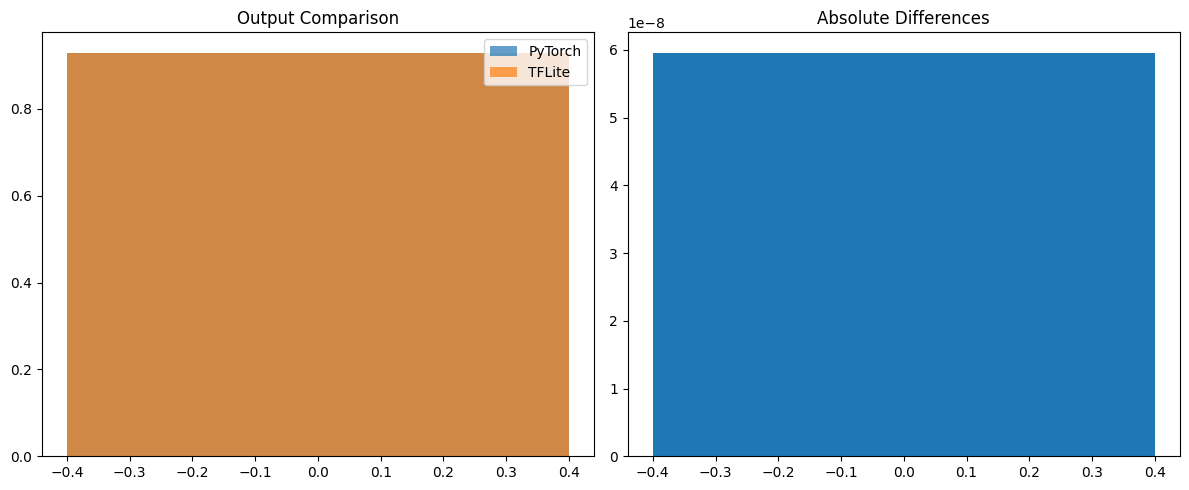


Test case 2:

=== Comparing model outputs ===
Maximum difference: 0.00000119
Mean difference: 0.00000119
Outputs match: True


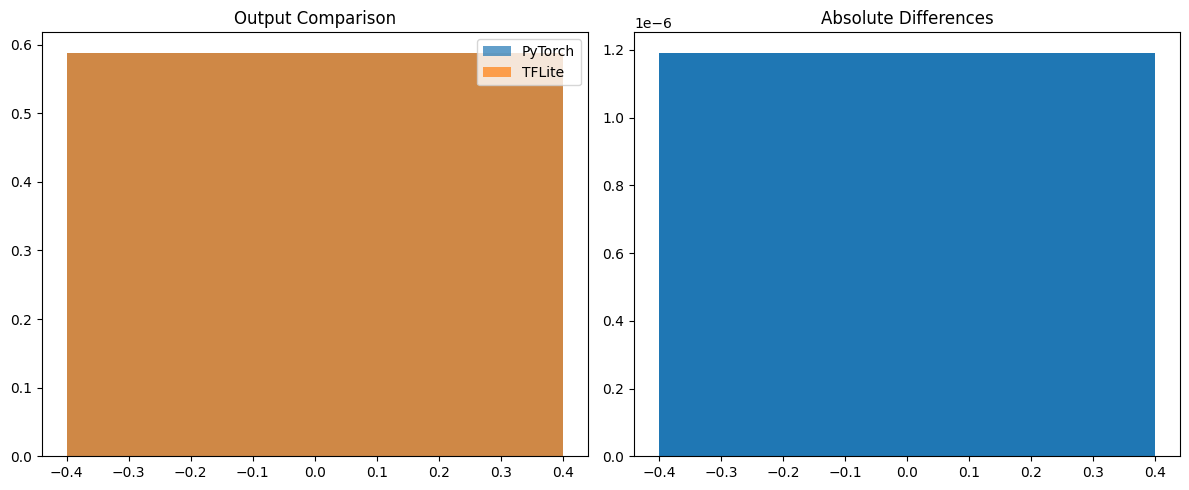


Test case 3:

=== Comparing model outputs ===
Maximum difference: 0.00000006
Mean difference: 0.00000006
Outputs match: True


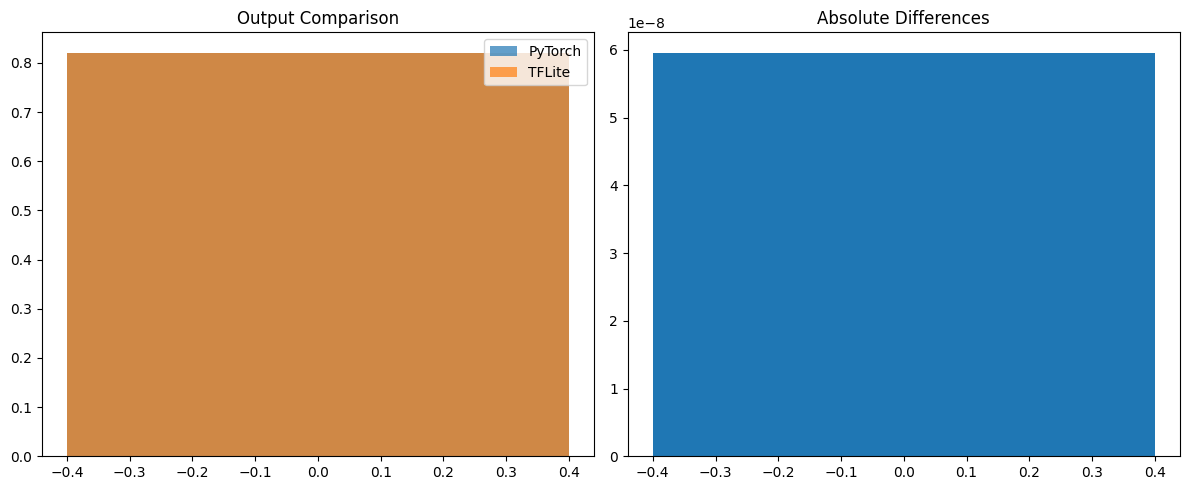


Test case 4:

=== Comparing model outputs ===
Maximum difference: 0.00000006
Mean difference: 0.00000006
Outputs match: True


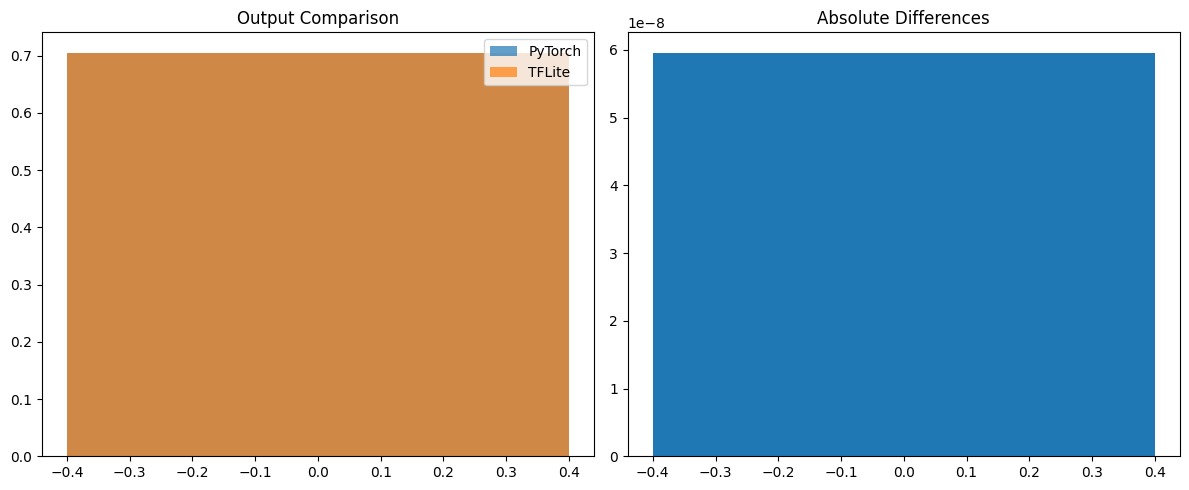


7. Testing the TFLite model directly

=== Testing TFLite model: fall_detection_model.tflite ===
Input details: [{'name': 'serving_default_args_0:0', 'index': 0, 'shape': array([  1, 128,   4], dtype=int32), 'shape_signature': array([  1, 128,   4], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output details: [{'name': 'StatefulPartitionedCall:0', 'index': 231, 'shape': array([1, 1], dtype=int32), 'shape_signature': array([1, 1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Running inference...
Raw output: [0.93008304]
Binary predictions (threshold=0.5): [1]

8. Conversion process completed!
TFLite model saved to: fall

/home/abheekp/tousifWeights/Torch_tflite/AI_EDGE_TORCH/lib/python3.12/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [3]:
# Complete TransModel to TFLite Conversion Script
# Compatible with Jupyter Notebook execution

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import traceback
import tempfile
import matplotlib.pyplot as plt
import time
import io

# Try importing ai_edge_torch, showing helpful error if not available
try:
    import ai_edge_torch
    from ai_edge_torch.debug import find_culprits
except ImportError:
    print("Error: ai_edge_torch not found.")
    print("Please install it with: pip install ai-edge-torch")
    print("For more details, see: https://github.com/google-ai-edge/ai-edge-torch")

# ==============================
# Revised TransModel (Acc Only)
# ==============================

class TransModel(nn.Module):
    def __init__(self,
                acc_frames=128,
                num_classes=1, 
                num_heads=4, 
                acc_coords=4,  # x, y, z, smv
                num_layers=2, 
                norm_first=True, 
                embed_dim=32, 
                activation='relu',
                **kwargs):
        super().__init__()
        
        self.data_shape = (acc_frames, acc_coords)
        self.length = self.data_shape[0]
        
        # Input projection: Conv1D to transform input channels into embedding dimension
        self.input_proj = nn.Sequential(
            nn.Conv1d(acc_coords, embed_dim, kernel_size=8, stride=1, padding='same'), 
            nn.BatchNorm1d(embed_dim)
        )

        # Transformer encoder layers
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,  
            activation=activation, 
            dim_feedforward=embed_dim*2, 
            nhead=num_heads,
            dropout=0.5,
            norm_first=norm_first
        )
        
        # Transformer encoder
        self.encoder = nn.TransformerEncoder(
            encoder_layer=self.encoder_layer, 
            num_layers=num_layers, 
            norm=nn.LayerNorm(embed_dim)
        )

        # Output classifier
        self.temporal_norm = nn.LayerNorm(embed_dim)
        self.output = nn.Linear(embed_dim, num_classes)
    
    def forward(self, acc_data):
        """Forward pass that only takes accelerometer data"""
        batch_size = acc_data.shape[0]
        
        # Reshape input: [batch, frames, channels] -> [batch, channels, frames]
        x = acc_data.permute(0, 2, 1)
        
        # Apply convolutional projection
        x = self.input_proj(x)  # Shape: [batch, embed_dim, frames]
        
        # Reshape for transformer: [batch, embed_dim, frames] -> [frames, batch, embed_dim]
        x = x.permute(2, 0, 1)
        
        # Apply transformer encoder
        x = self.encoder(x)  # Shape: [frames, batch, embed_dim]
        
        # Reshape back: [frames, batch, embed_dim] -> [batch, frames, embed_dim]
        x = x.permute(1, 0, 2)
        
        # Apply normalization
        x = self.temporal_norm(x)  # Shape: [batch, frames, embed_dim]
        
        # Global average pooling across time dimension
        # [batch, frames, embed_dim] -> [batch, embed_dim, frames]
        x = x.permute(0, 2, 1)
        x = F.avg_pool1d(x, kernel_size=x.shape[2], stride=1)  # Shape: [batch, embed_dim, 1]
        x = x.squeeze(-1)  # Shape: [batch, embed_dim]
        
        # Final classification
        x = self.output(x)  # Shape: [batch, num_classes]
        
        return x

# ==============================
# Model Wrapper for Export
# ==============================

class TransModelWrapper(nn.Module):
    """Wrapper to ensure compatibility with torch.export and AI Edge Torch"""
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def forward(self, acc_data):
        # Get model prediction and apply sigmoid
        logits = self.model(acc_data)
        probs = torch.sigmoid(logits)
        return probs

# ==============================
# Conversion Utilities
# ==============================

def convert_model_to_tflite(model, sample_input, output_path, debug=True):
    """
    Convert PyTorch model to TFLite using AI Edge Torch
    
    Args:
        model: PyTorch model to convert
        sample_input: Sample input tensor for tracing
        output_path: Path to save the TFLite model
        debug: Enable debugging mode
    
    Returns:
        edge_model: Converted AI Edge Torch model
    """
    print("=== Starting model conversion ===")
    
    # Set model to evaluation mode
    model.eval()
    
    # Create the wrapper for export compatibility
    print("Creating export-compatible wrapper...")
    wrapper = TransModelWrapper(model)
    wrapper.eval()
    
    try:
        # Start conversion
        print("Converting to AI Edge model...")
        conversion_start = time.time()
        
        # Convert model to AI Edge format
        edge_model = ai_edge_torch.convert(wrapper, (sample_input,))
        
        conversion_time = time.time() - conversion_start
        print(f"Conversion completed in {conversion_time:.2f} seconds")
        
        # Export to TFLite
        print(f"Exporting to TFLite format at: {output_path}")
        edge_model.export(output_path)
        
        # Verify the conversion by comparing outputs
        print("\n=== Verifying conversion accuracy ===")
        with torch.no_grad():
            pytorch_output = wrapper(sample_input).cpu().numpy()
        
        edge_output = edge_model(sample_input)
        
        # Compare outputs
        max_diff = np.max(np.abs(pytorch_output - edge_output))
        are_close = np.allclose(pytorch_output, edge_output, atol=1e-5)
        
        print(f"Max difference: {max_diff:.8f}")
        print(f"Outputs match: {are_close}")
        
        if are_close:
            print("✅ Conversion successful with matching outputs!")
        else:
            print("⚠️ Conversion completed but outputs don't match exactly.")
            
            # Show detailed comparison if differences are found
            if debug and not are_close:
                print("\nDetailed comparison:")
                print(f"PyTorch output: {pytorch_output.flatten()}")
                print(f"TFLite output: {edge_output.flatten()}")
        
        return edge_model
        
    except Exception as e:
        print(f"❌ Error during conversion: {str(e)}")
        
        if debug:
            print("\n=== DEBUG INFORMATION ===")
            traceback.print_exc()
            
            try:
                # Use AI Edge Torch's debugging tools to identify issues
                print("\nFinding culprits in the model...")
                culprits = find_culprits(wrapper, (sample_input,))
                
                if culprits:
                    print("\nProblematic operations found:")
                    for i, culprit in enumerate(culprits):
                        print(f"\n--- Culprit #{i+1} ---")
                        culprit.print_code()
                else:
                    print("No specific culprits identified.")
            except Exception as debug_e:
                print(f"Error during debugging: {str(debug_e)}")
        
        return None

def load_and_test_tflite(tflite_path, test_data):
    """
    Load and test a TFLite model
    
    Args:
        tflite_path: Path to the TFLite model
        test_data: Input data for testing
    
    Returns:
        predictions: Model predictions
    """
    try:
        # Try importing TensorFlow
        import tensorflow as tf
        
        print(f"\n=== Testing TFLite model: {tflite_path} ===")
        
        # Load the TFLite model
        interpreter = tf.lite.Interpreter(model_path=tflite_path)
        interpreter.allocate_tensors()
        
        # Get input and output details
        input_details = interpreter.get_input_details()
        output_details = interpreter.get_output_details()
        
        print(f"Input details: {input_details}")
        print(f"Output details: {output_details}")
        
        # Ensure test_data is in the right format (numpy array)
        if isinstance(test_data, torch.Tensor):
            test_data = test_data.numpy()
        
        # Set the input tensor
        interpreter.set_tensor(input_details[0]['index'], test_data)
        
        # Run inference
        print("Running inference...")
        interpreter.invoke()
        
        # Get the output
        output = interpreter.get_tensor(output_details[0]['index'])
        
        # Apply threshold for binary prediction
        predictions = (output > 0.5).astype(np.int32)
        
        print(f"Raw output: {output.flatten()}")
        print(f"Binary predictions (threshold=0.5): {predictions.flatten()}")
        
        return output
        
    except ImportError:
        print("TensorFlow not installed. Cannot test TFLite model.")
        print("Install with: pip install tensorflow")
        return None
    except Exception as e:
        print(f"Error testing TFLite model: {str(e)}")
        traceback.print_exc()
        return None

def compare_model_outputs(model, edge_model, test_data):
    """
    Compare outputs between original PyTorch model and converted model
    
    Args:
        model: Original PyTorch model
        edge_model: Converted AI Edge Torch model
        test_data: Test data for comparison
    """
    print("\n=== Comparing model outputs ===")
    
    # Set model to evaluation mode
    model.eval()
    
    # Create wrapper for consistent output format
    wrapper = TransModelWrapper(model)
    
    # Get outputs from both models
    with torch.no_grad():
        torch_output = wrapper(test_data).cpu().numpy()
    
    edge_output = edge_model(test_data)
    
    # Calculate differences
    max_diff = np.max(np.abs(torch_output - edge_output))
    mean_diff = np.mean(np.abs(torch_output - edge_output))
    are_close = np.allclose(torch_output, edge_output, atol=1e-5)
    
    print(f"Maximum difference: {max_diff:.8f}")
    print(f"Mean difference: {mean_diff:.8f}")
    print(f"Outputs match: {are_close}")
    
    # Visualize differences
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.bar(range(len(torch_output.flatten())), torch_output.flatten(), label='PyTorch', alpha=0.7)
    plt.bar(range(len(edge_output.flatten())), edge_output.flatten(), label='TFLite', alpha=0.7)
    plt.title('Output Comparison')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.bar(range(len(torch_output.flatten())), np.abs(torch_output.flatten() - edge_output.flatten()))
    plt.title('Absolute Differences')
    
    plt.tight_layout()
    plt.show()

# ==============================
# Main Execution
# ==============================

def transfer_weights_if_needed(source_model, target_model):
    """
    Transfer weights from source model to target model if needed
    
    Args:
        source_model: Source model to transfer weights from
        target_model: Target model to transfer weights to
    
    Returns:
        target_model: Model with transferred weights
    """
    try:
        # Get state dictionaries
        source_state = source_model.state_dict()
        target_state = target_model.state_dict()
        
        # Track transferred parameters
        transferred = 0
        total_params = len(target_state)
        
        # Copy matching parameters
        print("Transferring weights from source model...")
        for name, param in target_state.items():
            if name in source_state:
                # Check if shapes match
                if source_state[name].shape == param.shape:
                    target_state[name].copy_(source_state[name])
                    transferred += 1
                else:
                    print(f"Shape mismatch for {name}: source {source_state[name].shape} vs target {param.shape}")
        
        # Load updated state into target model
        target_model.load_state_dict(target_state)
        
        print(f"Transferred {transferred}/{total_params} parameters")
        return target_model
    
    except Exception as e:
        print(f"Error transferring weights: {str(e)}")
        traceback.print_exc()
        return target_model

def run_full_conversion(
    model_path=None, 
    output_path="fall_detection_model.tflite", 
    model_args=None,
    test_cases=None
):
    """
    Run the complete conversion process including testing
    
    Args:
        model_path: Path to PyTorch model weights (optional)
        output_path: Path to save the TFLite model
        model_args: Arguments for model initialization
        test_cases: Sample test cases for verification
    """
    print("===============================================")
    print("   COMPLETE PYTORCH TO TFLITE CONVERSION")
    print("===============================================")
    
    # Default model arguments if not provided
    if model_args is None:
        model_args = {
            "num_layers": 2,
            "norm_first": True,
            "embed_dim": 32,
            "activation": "relu",
            "acc_coords": 4,  # x, y, z, smv
            "num_classes": 1,
            "acc_frames": 128,
            "num_heads": 4
        }
    
    print(f"Model configuration: {model_args}")
    
    # Create the accelerometer-only model
    print("\n1. Creating accelerometer-only model")
    acc_model = TransModel(**model_args)
    
    # Load weights if provided
    if model_path and os.path.exists(model_path):
        print(f"\n2. Loading weights from: {model_path}")
        
        try:
            # First try to load the model directly
            state_dict = torch.load(model_path, map_location='cpu')
            
            # Check if it's a full model or just state dict
            if isinstance(state_dict, dict) and 'state_dict' in state_dict:
                state_dict = state_dict['state_dict']
            
            # Try to load the state dict
            missing_keys, unexpected_keys = acc_model.load_state_dict(state_dict, strict=False)
            
            if missing_keys:
                print(f"Missing keys: {missing_keys}")
            if unexpected_keys:
                print(f"Unexpected keys: {unexpected_keys}")
                
            # If there's significant mismatch, try loading the original model
            if len(missing_keys) > 5 or len(unexpected_keys) > 5:
                print("\nTrying to load original model and transfer weights...")
                
                # Import original model if different from our implementation
                try:
                    from Models.transformer import TransModel as OriginalTransModel
                    original_model = OriginalTransModel(**model_args)
                    original_model.load_state_dict(state_dict, strict=False)
                    
                    # Transfer weights from original to our accelerometer-only model
                    acc_model = transfer_weights_if_needed(original_model, acc_model)
                    
                except ImportError:
                    print("Original model class not found, proceeding with partial weight loading")
        
        except Exception as e:
            print(f"Error loading weights: {str(e)}")
            traceback.print_exc()
    else:
        print("\n2. No weights file provided or file not found. Using random initialization.")
    
    # Set model to evaluation mode
    acc_model.eval()
    
    # Create sample input for tracing and testing
    print("\n3. Creating sample input for model tracing")
    
    # Default test cases if not provided
    if test_cases is None:
        # Create 3 test cases with different patterns
        test_cases = [
            torch.zeros(1, 128, 4),  # All zeros
            torch.ones(1, 128, 4),   # All ones
            torch.randn(1, 128, 4)   # Random values
        ]
    
    # Use the first test case for tracing
    sample_input = test_cases[0].float()
    
    # Run inference with PyTorch model for baseline
    print("\n4. Testing PyTorch model inference")
    acc_model.eval()
    with torch.no_grad():
        try:
            torch_output = acc_model(sample_input)
            print(f"PyTorch model output shape: {torch_output.shape}")
            print(f"Raw output: {torch_output.cpu().numpy().flatten()}")
            
            # Apply sigmoid and threshold to get binary prediction
            predictions = (torch.sigmoid(torch_output) > 0.5).int()
            print(f"Binary predictions: {predictions.cpu().numpy().flatten()}")
            
        except Exception as e:
            print(f"Error running PyTorch inference: {str(e)}")
            traceback.print_exc()
    
    # Convert model to TFLite
    print("\n5. Converting model to TFLite")
    edge_model = convert_model_to_tflite(acc_model, sample_input, output_path, debug=True)
    
    if edge_model is not None:
        # Test the converted model with all test cases
        print("\n6. Testing the converted model")
        
        for i, test_input in enumerate(test_cases):
            print(f"\nTest case {i+1}:")
            
            # Compare outputs between PyTorch and Edge models
            compare_model_outputs(acc_model, edge_model, test_input.float())
        
        # Test the TFLite model directly
        print("\n7. Testing the TFLite model directly")
        tflite_output = load_and_test_tflite(output_path, sample_input)
        
        print("\n8. Conversion process completed!")
        print(f"TFLite model saved to: {output_path}")
        
        return edge_model, tflite_output
    else:
        print("\nConversion failed. Please check the errors above.")
        return None, None

# Run the full conversion process with the specified weights
if __name__ == "__main__" or True:  # Always execute in Jupyter
    # Use the specified model path
    model_path = "ttfstudent_31_kd.pth"
    output_path = "fall_detection_model.tflite"
    
    # Create test cases with different patterns to verify robustness
    test_cases = [
        torch.zeros(1, 128, 4),           # All zeros
        torch.ones(1, 128, 4),            # All ones
        torch.randn(1, 128, 4),           # Random noise
        torch.sin(torch.linspace(0, 10*np.pi, 128)).unsqueeze(0).unsqueeze(2).repeat(1, 1, 4)  # Sine wave pattern
    ]
    
    # Run the full conversion process
    edge_model, tflite_output = run_full_conversion(
        model_path=model_path,
        output_path=output_path,
        test_cases=test_cases
    )